In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset-uci.csv to dataset-uci.csv


In [46]:
import pandas as pd
from numpy import mean
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [12]:
def printTable(data):
  col_widths = [max(len(str(val)) for val in [col] + data[col].astype(str).tolist()) for col in data.columns]

  header = " | ".join([str(col).ljust(width) for col, width in zip(data.columns, col_widths)])
  print(header)
  print("-" * len(header))

  for _, row in data.iterrows():
      row_str = " | ".join([str(row[col]).ljust(width) for col, width in zip(data.columns, col_widths)])
      print(row_str)

In [18]:
def load():
  dataPath = "dataset-uci.csv" #path data gallstone status
  data = pd.read_csv(dataPath, delimiter=";")

  data.replace('?', np.nan, inplace=True)

  print("GALLSTONE STATUS MODEL PREDICTION (VERBOSE)")
  print("-"*100)
  print()
  print("DATA TYPES AND FEATURES")
  print()
  print(data.info()) #Getting data type and features info
  print("-"*100)
  print()
  print("MISSING VALUES")
  print()
  print(data.isna().sum()) #Getting the number of missing values per feature
  print("-"*100)
  print()

  X = data.drop("Gallstone Status", axis=1)
  y = data["Gallstone Status"]

  return (X, y)

In [17]:
def encoderFunc(data):
  scaler = StandardScaler() #z-score scaling (mean and std. dev. needed)
  x_scaled = scaler.fit_transform(data)
  x_scaled = pd.DataFrame(x_scaled, columns=data.columns, index=data.index)
  return x_scaled

In [84]:
def lof(x_scaled, y_data, plot=True):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    y_predict = lof.fit_predict(x_scaled)

    novelty_scores = -lof.negative_outlier_factor_

    #Outlier threshold (percentile -> 90)
    threshold = np.percentile(novelty_scores, 90)

    #Label the row as outlier if value is up top threshold
    predicted_labels = np.where(y_predict == -1, 1, 0)
    anomaly_indices = np.where(predicted_labels == 1)[0]

    #Show index and number of outliers
    print()
    print("-" * 100)
    print()
    print(f"Detected outliers: {len(anomaly_indices)} rows")
    print(f"Deleted index: {anomaly_indices.tolist()}")
    print("-" * 100)

    #Clean X and y
    x_clean = pd.DataFrame(x_scaled).drop(index=anomaly_indices).reset_index(drop=True)
    y_clean = pd.Series(y_data.values.ravel()).drop(index=anomaly_indices).reset_index(drop=True)

    #Graphs
    if plot:
        #Novelty scores histogram
        plt.figure(figsize=(10, 4))
        sns.histplot(novelty_scores, bins=50, kde=True, color='skyblue')
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (p90): {threshold:.2f}')
        plt.title("Novelty scores distribution")
        plt.xlabel("Novelty score")
        plt.ylabel("Frecuency")
        plt.legend()
        plt.tight_layout()
        plt.show()
        print()

        # PCA para reducción a 2D (solo visualización)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(x_scaled)

        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[predicted_labels == 0, 0], X_pca[predicted_labels == 0, 1], c='blue', label='Inliner')
        plt.scatter(X_pca[predicted_labels == 1, 0], X_pca[predicted_labels == 1, 1], c='red', label='Outlier')
        plt.title("Outliers detected by LOF (PCA 2D)")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return x_clean, y_clean


In [85]:
def rfe_selected_features(X, y, estimator=None, n_features_to_select=5):
    if estimator is None:
        estimator = LogisticRegression(max_iter=1000)

    rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)
    rfe.fit(X, y)

    #Boolean mask of selected features
    mask = rfe.support_

    #Select only the selected cols
    selected_columns = X.columns[mask]
    X_reduced = X[selected_columns].copy()

    print()
    print("-"*100)
    print()
    print("Features selected by RFE:")
    for col in selected_columns:
        print(f" - {col}")

    return X_reduced


In [23]:
def supportVectorMachine_nestedCV(X, y):
  param_grid = [
      {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
      {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3], 'gamma': ['scale', 'auto']},
      {'kernel': ['linear'], 'C': [0.1, 1, 10]},
  ]

  #Cross validation to test the model
  outerCV = KFold(n_splits=5, shuffle=True, random_state=12)
  svc = SVC(class_weight='balanced')

  test_score_nested = []
  accuracy_scores = []
  precision_scores = []
  recall_scores = []
  f1_scores = []

  all_y_test = []
  all_y_pred = []

  plt.figure(figsize=(10, 8))

  for i, (train_index, test_index) in enumerate(outerCV.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    innerCV = KFold(n_splits=5, shuffle=True, random_state=i)
    model = GridSearchCV(estimator=svc, param_grid=param_grid, cv=innerCV)
    model.fit(X_train, y_train)
    print(f"Mejores hiper-parametros para fold {i}: {model.best_params_}")
    print(f"Mejor score para fold {i}: {model.best_score_}")

    y_pred_fold = model.predict(X_test)

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred_fold)

    precision = precision_score(y_test, y_pred_fold, pos_label=1) #we are gonna check the metrics based on malignant cases (target = 1)
    recall = recall_score(y_test, y_pred_fold, pos_label=1)
    f1 = f1_score(y_test, y_pred_fold, pos_label=1)
    acc = accuracy_score(y_test, y_pred_fold)

    print(f"Fold {i}: accuracy={acc:.2f}, precision={precision:.2f}, recall={recall:.2f}, f1-score={f1:.2f}")

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    test_score_nested.append(model.score(X_test, y_test))

  print("\n mean scores")
  print(f"Mean accuracy: {mean(accuracy_scores):.2f}")
  print(f"Mean precision: {mean(precision_scores):.2f}")
  print(f"Mean recall: {mean(recall_scores):.2f}")
  print(f"Mean f1-score: {mean(f1_scores):.2f}") #This is the most important metric to see the correct real malignant pred.

  print("\n test score en folds outer")
  for i, score in enumerate(test_score_nested):
    print(f"Fold {i}: test_score={score:.2f}")

  print("\n mean test score")
  print(f"Mean test score: {mean(test_score_nested):.2f}")

  final_conf_matrix = confusion_matrix(all_y_test, all_y_pred, labels=[0,1])
  print("\n confusion matrix")
  disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix, display_labels=[0,1])
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

In [26]:
def SVMglobalModel(X, y):
  param_grid = [
      {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
      {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3], 'gamma': ['scale', 'auto']},
      {'kernel': ['linear'], 'C': [0.1, 1, 10]},
  ]
  best_model = GridSearchCV(estimator=SVC(class_weight='balanced'), param_grid=param_grid, cv=5)
  best_model.fit(X, y)
  print("Best global Hiperparams:", best_model.best_params_)

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  all_y_test = []
  all_y_pred = []

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      model = best_model.best_estimator_
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      all_y_test.extend(y_test)
      all_y_pred.extend(y_pred)

  print(classification_report(all_y_test, all_y_pred, target_names=["Benign (0)", "Malignant (1)"]))

  cm = confusion_matrix(all_y_test, all_y_pred, labels=[0, 1])

  print("Confusion Matrix:")
  print(cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix - SVM")
  plt.show()


In [70]:
def plotFeature(model,colN):
  for feature in zip(colN,model.feature_importances_):
    print(feature)
  sortedIdx=model.feature_importances_.argsort()
  colN=np.array(colN)
  plt.barh(colN[sortedIdx],model.feature_importances_[sortedIdx])
  plt.show()
  print(model.feature_importances_[sortedIdx])

In [71]:
def randomForest_best_HP(X, y, colN):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  nEst = [] # number of stimators (inner trees)
  for i in range(1,200,3):
    nEst.append(i)

  acc = [] # Accuracy
  oob_error = [] # out of bag --> to see the generalization error of the model

  print()
  for i in nEst:
    clf = RandomForestClassifier(n_estimators=i, oob_score=True, random_state=0)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    score=accuracy_score(y_test,y_pred)
    print(f"For {i} nEstimators -> Accuracy: {score:.2f}")
    acc.append(score)
    oob_error.append(1-clf.oob_score_)

  plt.figure(1)
  plt.plot(nEst,oob_error)
  plt.xlabel("number of trees")
  plt.ylabel("oob")
  plt.legend()
  index_max=max(range(len(acc)),key=acc.__getitem__)
  plt.figure(2)
  plotFeature(clf,colN)

In [81]:
def randomForest_CV_forHPs(X, y):
  param_grid = {
      'n_estimators': [100,105,110,115,120,125],
      'max_depth': [None, 10, 20, 30],
      'min_samples_split': [2, 5],
      'max_features': ['sqrt', 'log2'],
  }

  rf = RandomForestClassifier(oob_score=True, random_state=0)
  best_model = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
  best_model.fit(X, y)
  print("Best params:", best_model.best_params_)

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  all_y_test = []
  all_y_pred = []

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      model = best_model.best_estimator_
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      all_y_test.extend(y_test)
      all_y_pred.extend(y_pred)

  print(classification_report(all_y_test, all_y_pred, target_names=["Benign (0)", "Malignant (1)"]))

  cm = confusion_matrix(all_y_test, all_y_pred, labels=[0, 1])

  print("Confusion Matrix:")
  print(cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix - SVM")
  plt.show()

In [82]:
def main():
  X, y = load() #Load dataframes to variables
  print("TABLE FEATURES X")
  print()
  printTable(X) #Print inicial values of X
  print("-"*100)
  print()
  print("TABLE TARGET Y") #Print inicial values of y
  print()
  print(y)

  #Scaling data using z-score (better for SVM, not necessary for RF)
  X_scaled = encoderFunc(X)
  print()
  print("-"*100)
  print("SCALED DATA")
  print()
  printTable(X_scaled)

  #Detecting and deleting outliers (with LOF)
  X_without_outliers, y_without_outliers = lof(X_scaled, y)
  print()
  print("-"*100)
  print("DATA WITHOUT OUTLIERS")
  print()
  printTable(X_without_outliers)

  #Selecting the best features to rain the model
  X_selected = rfe_selected_features(X_without_outliers, y_without_outliers, n_features_to_select=20)

  #Nested Cross Validation to see the generalization of the SVM Model (acc )
  print()
  print("-"*100)
  print("SUPPORT VECTOR MACHINE (SVM) METRICS -NESTED CV-:")
  print()
  supportVectorMachine_nestedCV(X_selected, y_without_outliers)
  print()

  #Selecting HPs with a simple GridSearch --> compare to nested
  print()
  print("-"*100)
  print("SUPPORT VECTOR MACHINE (SVM) BEST HPs WITH SIMPLE GRIDSEARCH:")
  print()
  SVMglobalModel(X_selected, y_without_outliers)
  print()

  #Trying RF model to expect increase f1 (malignant detection)
  print()
  print("-"*100)
  print("RANDOM FOREST (RF) USING SCC AND OOB ERROR TO SELECT BEST N_TREES:")
  print()
  randomForest_best_HP(X, y, X.columns)

  #Selecting the best n_trees and use CV to select the best HPs for the model
  print()
  print("-"*100)
  print("RANDOM FOREST (RF) USING CV TO SELECT BEST HPS:")
  print()
  randomForest_CV_forHPs(X, y)

GALLSTONE STATUS MODEL PREDICTION (VERBOSE)
----------------------------------------------------------------------------------------------------

DATA TYPES AND FEATURES

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 39 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Gallstone Status                                319 non-null    int64  
 1   Age                                             319 non-null    int64  
 2   Gender                                          319 non-null    int64  
 3   Comorbidity                                     319 non-null    int64  
 4   Coronary Artery Disease (CAD)                   319 non-null    int64  
 5   Hypothyroidism                                  319 non-null    int64  
 6   Hyperlipidemia                                  319 non-null    int64  
 7   Diabetes Mellitus (DM)    

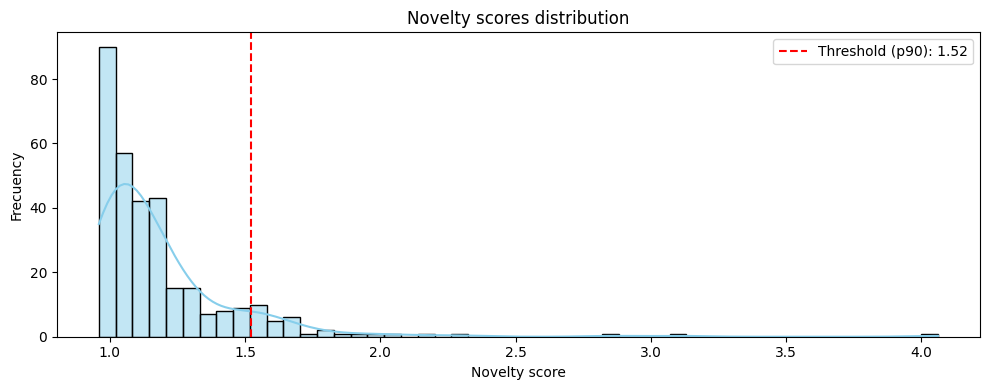

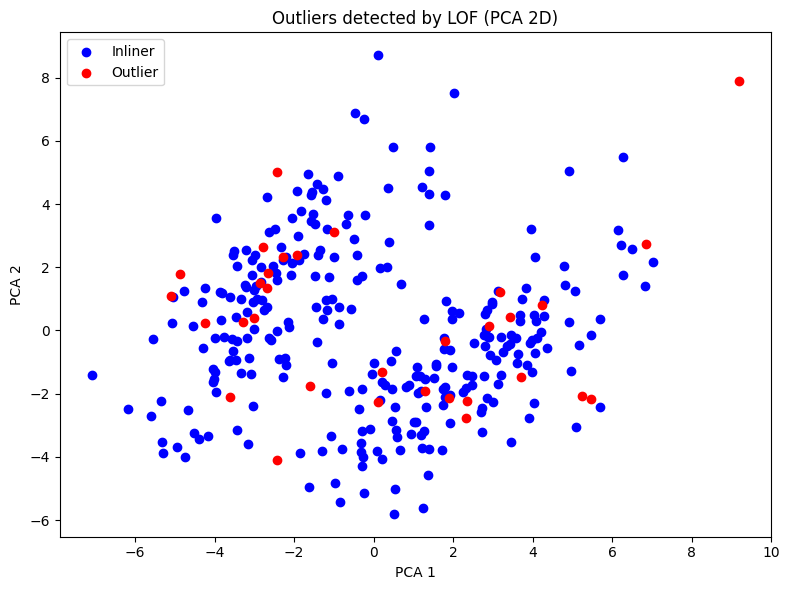


----------------------------------------------------------------------------------------------------
DATA WITHOUT OUTLIERS

Age                  | Gender              | Comorbidity         | Coronary Artery Disease (CAD) | Hypothyroidism       | Hyperlipidemia      | Diabetes Mellitus (DM) | Height                | Weight                | Body Mass Index (BMI) | Total Body Water (TBW) | Extracellular Water (ECW) | Intracellular Water (ICW) | Extracellular Fluid/Total Body Water (ECF/TBW) | Total Body Fat Ratio (TBFR) (%) | Lean Mass (LM) (%)    | Body Protein Content (Protein) (%) | Visceral Fat Rating (VFR) | Bone Mass (BM)        | Muscle Mass (MM)      | Obesity (%)            | Total Fat Content (TFC) | Visceral Fat Area (VFA) | Visceral Muscle Area (VMA) (Kg) | Hepatic Fat Accumulation (HFA) | Glucose               | Total Cholesterol (TC) | Low Density Lipoprotein (LDL) | High Density Lipoprotein (HDL) | Triglyceride          | Aspartat Aminotransferaz (AST) | Alanin Aminotransf

<Figure size 1000x800 with 0 Axes>

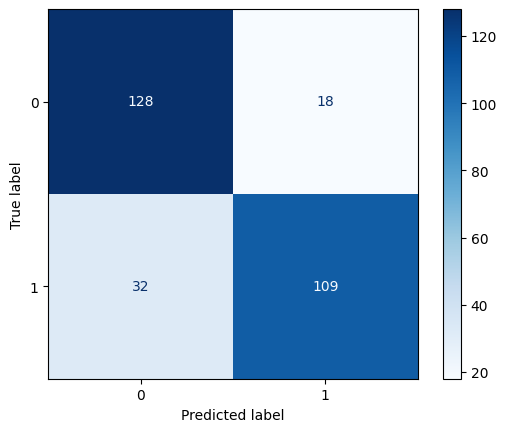



----------------------------------------------------------------------------------------------------
SUPPORT VECTOR MACHINE (SVM) BEST HPs WITH SIMPLE GRIDSEARCH:

Best global Hiperparams: {'C': 1, 'kernel': 'linear'}
               precision    recall  f1-score   support

   Benign (0)       0.82      0.90      0.86       146
Malignant (1)       0.88      0.79      0.84       141

     accuracy                           0.85       287
    macro avg       0.85      0.85      0.85       287
 weighted avg       0.85      0.85      0.85       287

Confusion Matrix:
[[131  15]
 [ 29 112]]


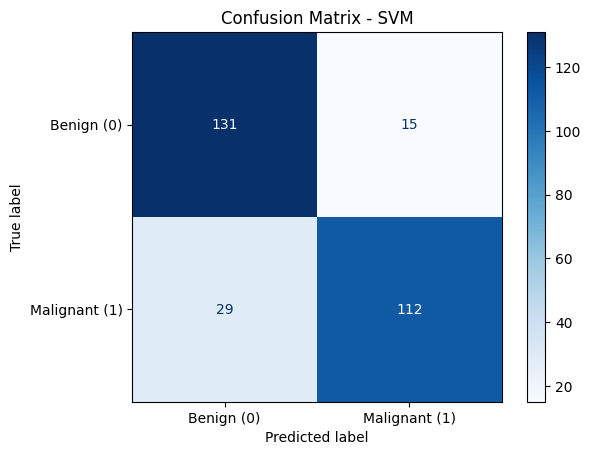



----------------------------------------------------------------------------------------------------
RANDOM FOREST (RF) USING SCC AND OOB ERROR TO SELECT BEST N_TREES:


For 1 nEstimators -> Accuracy: 0.58
For 4 nEstimators -> Accuracy: 0.64
For 7 nEstimators -> Accuracy: 0.70
For 10 nEstimators -> Accuracy: 0.72
For 13 nEstimators -> Accuracy: 0.78
For 16 nEstimators -> Accuracy: 0.75
For 19 nEstimators -> Accuracy: 0.75
For 22 nEstimators -> Accuracy: 0.75
For 25 nEstimators -> Accuracy: 0.78
For 28 nEstimators -> Accuracy: 0.78
For 31 nEstimators -> Accuracy: 0.77
For 34 nEstimators -> Accuracy: 0.78
For 37 nEstimators -> Accuracy: 0.77
For 40 nEstimators -> Accuracy: 0.77
For 43 nEstimators -> Accuracy: 0.73
For 46 nEstimators -> Accuracy: 0.78
For 49 nEstimators -> Accuracy: 0.78
For 52 nEstimators -> Accuracy: 0.80
For 55 nEstimators -> Accuracy: 0.80
For 58 nEstimators -> Accuracy: 0.78
For 61 nEstimators -> Accuracy: 0.80
For 64 nEstimators -> Accuracy: 0.81
For 67 nEstimator

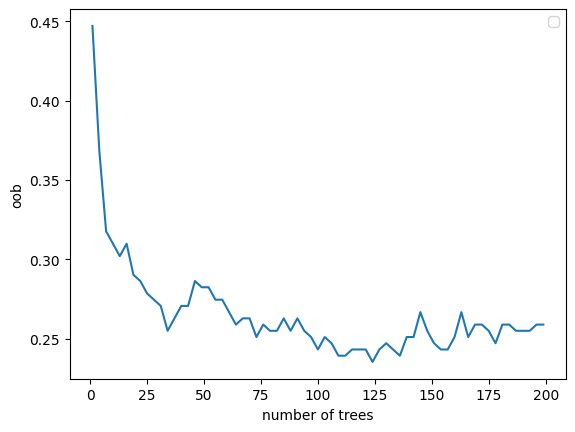

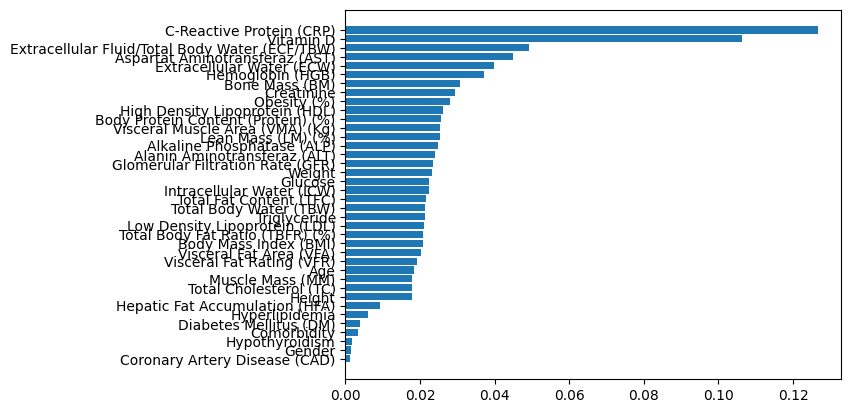

[0.00134082 0.00157717 0.00188124 0.0033426  0.00387658 0.00600221
 0.00931273 0.01784886 0.01790614 0.01791142 0.01843624 0.0190959
 0.02016281 0.02081045 0.02082442 0.02093145 0.02120698 0.02127908
 0.0216166  0.02233252 0.02246625 0.02314239 0.02357334 0.02410202
 0.02473665 0.02524208 0.02532183 0.02560881 0.02602204 0.02804448
 0.02934392 0.03074661 0.03709579 0.03969795 0.0449172  0.04928478
 0.10632301 0.12663465]

----------------------------------------------------------------------------------------------------
RANDOM FOREST (RF) USING CV TO SELECT BEST HPS:

Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}
               precision    recall  f1-score   support

   Benign (0)       0.76      0.83      0.79       161
Malignant (1)       0.81      0.73      0.77       158

     accuracy                           0.78       319
    macro avg       0.78      0.78      0.78       319
 weighted avg       0.78      0.78      0.78 

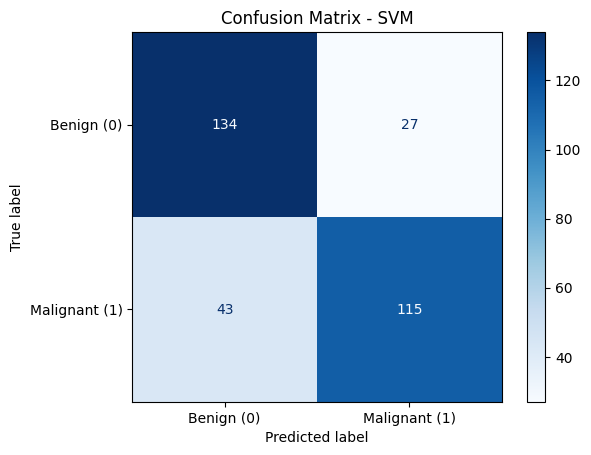

In [86]:
main()